In [1]:
import numpy as np
import matplotlib.pyplot as plt
import yaml
import sys
sys.path.insert(0,'/Users/ruhl/code/jbolo/python/')
from  jbolo_funcs import *

In [2]:
!ls yamls

CHLAT_20211210.yaml          SPLAT_20211210.yaml
SAT_HF_20211210.yaml         SPLAT_20211210_bandfile.yaml
SAT_HF_20220216.yaml         spt3g.yaml
SAT_LFMF_20211210.yaml       test.yaml
SAT_LFMF_20220216.yaml


In [3]:
FIXED_PSAT = True

In [5]:
def pwv_vary(yamlfile,site,def_pwv):
    #expt_yaml = 'yamls/SAT_LFMF_20211210.yaml'
    sim = yaml.safe_load(open(yamlfile))
    
    # overload yamls, so we can easily change where a telescope is sited.
    sim['sources']['atmosphere']['site']=site
    sim['sources']['atmosphere']['pwv']=def_pwv  #used to find Psats if not specified, in initial run.
    #sim['optical_elements']['window']['thickness']=0.02
    chlist = list(sim['channels'].keys())
    if FIXED_PSAT:
        if (sim['bolo_config']['psat_method'] != 'specified'):
            run_optics(sim)
            run_bolos(sim)
            sim['bolo_config']['psat_method'] = 'specified'
            for ch in chlist:
                sim['channels'][ch]['psat']=sim['outputs'][ch]['P_sat']
                
    out_NET = {}
    out_Popt = {}
    for ch in chlist:
        out_NET[ch] = np.array([])
        out_Popt[ch]= np.array([])
    
    out_pwv = np.arange(0,5000,100)
    for pwv in out_pwv:
        sim['sources']['atmosphere']['pwv'] = pwv
        run_optics(sim)
        run_bolos(sim)
        for ch in chlist:
            out_NET[ch] = np.append(out_NET[ch],sim['outputs'][ch]['NET_NC_total'])
            out_Popt[ch] = np.append(out_Popt[ch],sim['outputs'][ch]['P_opt'])
      
    return(out_pwv, out_Popt, out_NET,chlist)



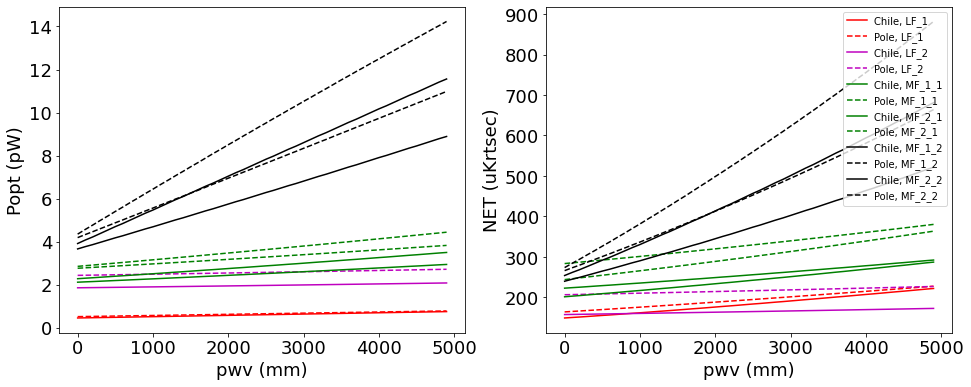

In [13]:
%matplotlib inline
plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = [16, 6]

yamlfile = 'yamls/SAT_LFMF_20220216.yaml'

fig, axs = plt.subplots(1,2)

# check whether sim exists, and if it does, clear it so we don't get confused.
if "sim" in locals():
    sim.clear()

pwv, Popt_chile, NET_chile, chlist = pwv_vary(yamlfile, 'Atacama',993)
pwv, Popt_pole, NET_pole, chlist = pwv_vary(yamlfile, 'Pole',321)

chcolor = {'LF_1':'r', 'LF_2':'m', 'MF_1_1':'g', 'MF_2_1':'g', 'MF_1_2':'k', 'MF_2_2':'k', 'HF_1':'c','HF_2':'b'}
for ch in chlist:
    ltype = chcolor[ch]
    labelstr = 'Chile, '+ch
    axs[0].plot(pwv,Popt_chile[ch]*1e12, ltype,label=labelstr)
    axs[1].plot(pwv,NET_chile[ch]*1e6, ltype,label=labelstr)
    ltype = ltype+'--'
    labelstr = 'Pole, '+ch
    axs[0].plot(pwv,Popt_pole[ch]*1e12,ltype, label=labelstr)
    axs[1].plot(pwv,NET_pole[ch]*1e6,ltype, label = labelstr)
    
axs[0].set_xlabel('pwv (mm)')
axs[0].set_ylabel('Popt (pW)')
#axs[0].legend(fontsize=10,loc='upper right')

axs[1].set_xlabel('pwv (mm)')
axs[1].set_ylabel('NET (uKrtsec)')
axs[1].legend(fontsize=10,loc='upper right')



#axs[1].text(500,500,'hey')


# pwv histograms

Atacama median pwv: 1.232 mm
Pole median pwv: 0.396 mm


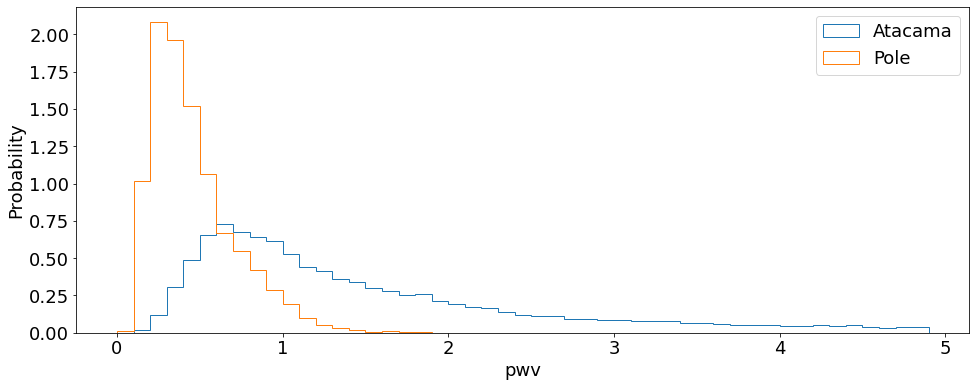

In [14]:
#### Sort the pwv's into a single time-ordered vector and plot histogram;  
# This lets you plot the timestream if desired.
import pickle

pwvs = np.array([])
d = pickle.load(open("atmos/Merra2_atmos_atacama.pck", "rb"))
for ii in np.arange(0,290):
    for month in np.arange(4,12):  # skip jan/feb/march
        for hour in np.arange(0,24):
            pwvs = np.append(pwvs,d[month]['TQV'][hour][ii])
print('Atacama median pwv: {0:5.3f} mm'.format(np.median(pwvs)))

#pwv_bins = np.arange(0,10,0.1) 
pwv_bins = pwv/1000

A_chile = plt.hist(pwvs, bins=pwv_bins, histtype='step',density=True, label='Atacama')

pwvs = np.array([])
d = pickle.load(open("atmos/Merra2_atmos_pole.pck", "rb"))
for ii in np.arange(0,290):
    for month in np.arange(0,11):  # skip december
        for hour in np.arange(0,24):
            pwvs = np.append(pwvs,d[month]['TQV'][hour][ii])
print('Pole median pwv: {0:5.3f} mm'.format(np.median(pwvs)))
A_pole = plt.hist(pwvs, bins=pwv_bins, histtype='step',density=True, label='Pole')

plt.xlabel('pwv')
plt.ylabel('Probability')
plt.legend()


LF_1
  Chile weight:  40094280
  Pole  weight:  37009978
  Chile/Pole weight ratio:  1.083
LF_2
  Chile weight:  35922116
  Pole  weight:  23382731
  Chile/Pole weight ratio:  1.536
MF_1_1
  Chile weight:  15393784
  Pole  weight:  12416111
  Chile/Pole weight ratio:  1.240
MF_2_1
  Chile weight:  18812918
  Pole  weight:  16770492
  Chile/Pole weight ratio:  1.122
MF_1_2
  Chile weight:  11004873
  Pole  weight:  14050596
  Chile/Pole weight ratio:  0.783
MF_2_2
  Chile weight:   9811133
  Pole  weight:  13288110
  Chile/Pole weight ratio:  0.738


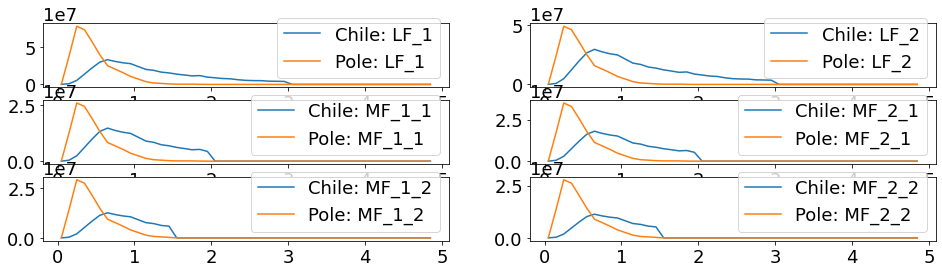

In [17]:
# Histogram has fewer points than the pwv vector;  its binning vector sets the left side of each bin, and right side of last bin.
# Bin centers are offset by a half a bin.
pwv_bin_centers = (A_chile[1][0:-1]+A_chile[1][1:])/2

# Linearly interpolate NET's to those same bin centers, and calculate weights
w_chile = {}
w_pole = {}
w_ratio = {}
cuts = {'LF_1':3, 
        'LF_2':3, 
        'MF_1_1':2, 
        'MF_2_1':2, 
        'MF_1_2':1.5, 
        'MF_2_2':1.5,
        'HF_1':1.0,
        'HF_2':1.0}

for ch in chlist:
    cut_level = cuts[ch]
    
    cut_vector = np.where(pwv_bin_centers<cut_level,1,0)
    
    NET_chile_onbins = np.interp(pwv_bin_centers,pwv, NET_chile[ch])
    NET_pole_onbins =  np.interp(pwv_bin_centers,pwv, NET_pole[ch])
    w_chile[ch] = (A_chile[0]*cut_vector)/NET_chile_onbins**2
    w_pole[ch] =  (A_pole[0]*cut_vector)/NET_pole_onbins**2
    w_chile_tot = np.trapz(w_chile[ch],pwv_bin_centers)
    w_pole_tot = np.trapz(w_pole[ch],pwv_bin_centers)
    w_ratio[ch]=w_chile_tot/w_pole_tot
    print(ch)
    print('  Chile weight: {0:9.0f}'.format(w_chile_tot))
    print('  Pole  weight: {0:9.0f}'.format(w_pole_tot))
    print('  Chile/Pole weight ratio: {0:6.3f}'.format(w_ratio[ch]))

#Make a plot
plt.rcParams['figure.figsize'] = [16, 4]
n_plots = len(chlist)
n_cols = 2
n_rows = int(np.ceil(n_plots/n_cols))

for ii in np.arange(0,n_plots):
    plt.subplot(n_rows,n_cols,ii+1)
    ch = chlist[ii]
    label1 = 'Chile: '+ch
    label2 = 'Pole: '+ch
    plt.plot(pwv_bin_centers,w_chile[ch], label = label1)
    plt.plot(pwv_bin_centers,w_pole[ch], label = label2)
    plt.legend()




In [11]:
for ch in chlist:
    if 'LF' in ch:
        ntubes = 5
    elif 'MF' in ch:
        ntubes = 3
    elif 'HF' in ch:
        ntubes = 2 

In [4]:
myvecname = {'vname':'aa'}
aa = np.array([1,2,4])
print(myvecname['vname'])

aa
